# RPI with TensorFlow Lite - Generating a Training Model
Developed by Marcelo Rovai - 19Aug20

- Inspired by [Deploy your deep learning models on IoT devices using TensorFlow lite](https://medium.com/datadriveninvestor/deploy-your-deep-learning-models-on-iot-devices-using-tensorflow-lite-99d3ccdfc853) by [Samarth Gupta](https://medium.com/@samarth0174?source=post_page-----99d3ccdfc853----------------------)

## Import Libraries

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [95]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix

## Dataset

- [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) is a dataset of 50,000 32x32 color training images, labeled over 10 categories, and 10,000 test images.
![image](cifar10_plot.png)

## Data preparation

In [63]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [64]:
x_train.shape

(50000, 32, 32, 3)

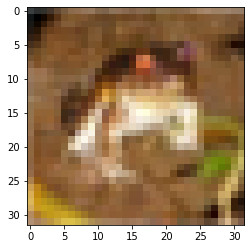

In [65]:
plt.imshow(x_train[0]) # Frog

In [67]:
y_train[0] # 6: Frog

array([6], dtype=uint8)

In [68]:
x_train.max()

255

In [69]:
x_train = x_train/255
x_test = x_test/255

In [70]:
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [71]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [72]:
y_cat_train = to_categorical(y_train,10)
y_cat_train.shape

(50000, 10)

In [73]:
y_cat_test = to_categorical(y_test,10)
y_cat_test.shape

(10000, 10)

## Define model

In [88]:
model = Sequential()

model.add(
    Conv2D(
        filters=32,
        kernel_size=(4, 4),
        input_shape=(32, 32, 3),
        activation='relu',
    ))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(
    Conv2D(
        filters=32,
        kernel_size=(4, 4),
        input_shape=(32, 32, 3),
        activation='relu',
    ))
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 29, 29, 32)        1568      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 11, 11, 32)        16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               205056    
_________________________________________________________________
dense_13 (Dense)             (None, 10)               

In [89]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Train and save model

In [90]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [91]:
history = model.fit(x_train,
                    y_cat_train,
                    epochs=20,
                    validation_data=(x_test, y_cat_test),
                    callbacks=[early_stop])

Epoch 1/20
1563/1563 [==============================] - 30s 19ms/step - loss: 1.4817 - accuracy: 0.4652 - val_loss: 1.2897 - val_accuracy: 0.5344
Epoch 2/20
1563/1563 [==============================] - 30s 19ms/step - loss: 1.1640 - accuracy: 0.5888 - val_loss: 1.0923 - val_accuracy: 0.6141
Epoch 3/20
1563/1563 [==============================] - 30s 19ms/step - loss: 1.0177 - accuracy: 0.6425 - val_loss: 1.0441 - val_accuracy: 0.6368
Epoch 4/20
1563/1563 [==============================] - 28s 18ms/step - loss: 0.9052 - accuracy: 0.6853 - val_loss: 1.0272 - val_accuracy: 0.6430
Epoch 5/20
1563/1563 [==============================] - 29s 18ms/step - loss: 0.8141 - accuracy: 0.7185 - val_loss: 0.9585 - val_accuracy: 0.6610
Epoch 6/20
1563/1563 [==============================] - 29s 18ms/step - loss: 0.7366 - accuracy: 0.7431 - val_loss: 0.9488 - val_accuracy: 0.6716
Epoch 7/20
1563/1563 [==============================] - 29s 19ms/step - loss: 0.6607 - accuracy: 0.7682 - val_loss: 0.9379 -

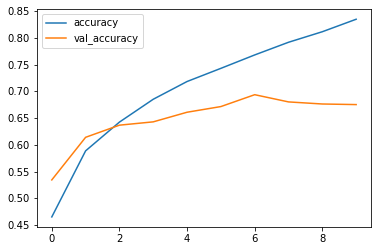

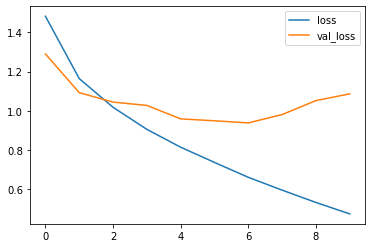

In [92]:
losses = pd.DataFrame(model.history.history)
losses[['accuracy','val_accuracy']].plot()
losses[['loss','val_loss']].plot()

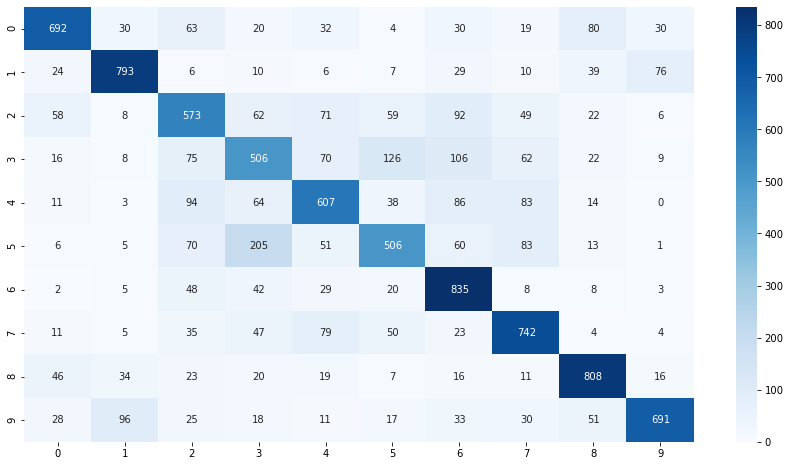

In [100]:
#predictions = model.predict_classes(x_test)
predictions = np.argmax(model.predict(x_test), axis=-1)
plt.figure(figsize=(15, 8))
sns.heatmap(confusion_matrix(y_test, predictions),
            cmap='Blues',
            annot=True,
            fmt='g');

In [101]:
model.save('./models/cifar10_model.h5')

## Testing model

In [174]:
classes_lst = ['Airplane', 'Automobile', 'Bird', 'Cat',
               'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

In [164]:
classes_lst[0]

'Airplane'

In [168]:
def predict_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (32, 32)) 
    pred = model.predict_classes(img.reshape(1,32,32,3))[0]
    print("\n\t[PREDICTION]: ", classes_lst[pred])
    plt.imshow(img);

In [169]:
!ls ./data/images/

car_1.jpg  car_3.jpg  car_5.jpg  cat_2.jpg  dog_1.jpg  dog_3.jpg  ship_2.jpg
car_2.jpg  car_4.jpg  cat_1.jpg  cat_2.png  dog_2.jpg  ship_1.jpg



	[PREDICTION]:  Dog


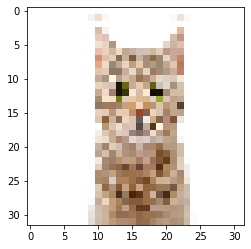

In [171]:
image_path = "./data/images/cat_1.jpg"
predict_image(image_path)


	[PREDICTION]:  Cat


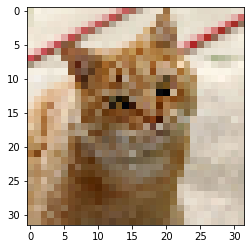

In [170]:
image_path = "./data/images/cat_2.jpg"
predict_image(image_path)


	[PREDICTION]:  Dog


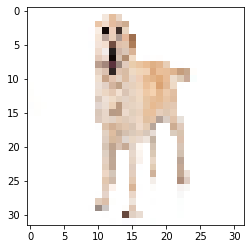

In [172]:
image_path = "./data/images/dog_1.jpg"
predict_image(image_path)


	[PREDICTION]:  Automobile


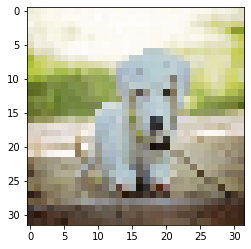

In [175]:
image_path = "./data/images/dog_2.jpg"
predict_image(image_path)


	[PREDICTION]:  Dog


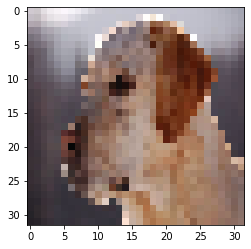

In [176]:
image_path = "./data/images/dog_3.jpg"
predict_image(image_path)


	[PREDICTION]:  Automobile


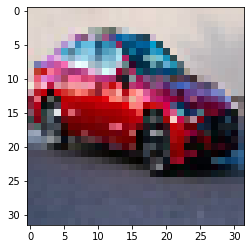

In [177]:
image_path = "./data/images/car_1.jpg"
predict_image(image_path)


	[PREDICTION]:  Automobile


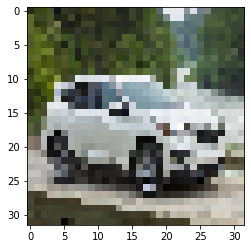

In [178]:
image_path = "./data/images/car_2.jpg"
predict_image(image_path)


	[PREDICTION]:  Automobile


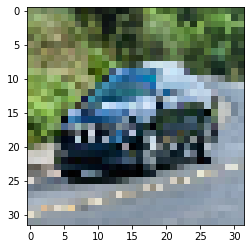

In [179]:
image_path = "./data/images/car_3.jpg"
predict_image(image_path)


	[PREDICTION]:  Truck


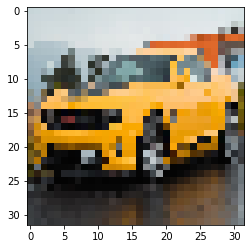

In [180]:
image_path = "./data/images/car_4.jpg"
predict_image(image_path)

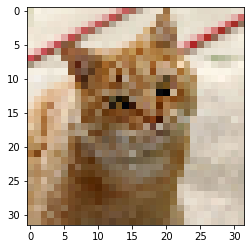

In [159]:
plt.imshow(img);

## Converting model to TF-Lite

In [181]:
model_cifar10 = tensorflow.keras.models.load_model('./models/cifar10_model.h5')
converter = tensorflow.lite.TFLiteConverter.from_keras_model(model_cifar10)

In [182]:
#save tflite model
tflite_model = converter.convert()
open("./models/cifar10.tflite","wb").write(tflite_model)

905312